<div align="center">

![fluxograma_teste_ab_bayesiano_atualizado.png](images\fluxograma_teste_ab_bayesiano_atualizado.png)

</div>


## Import

In [ ]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import multiprocessing

## Dados simulados

In [66]:
# Dados iniciais para conteole e tratamento
control_data = [8.1, 7.5, 8.2, 8.0] # Dados observados inicialmente para o grupo controle
treatment_data = [9.3, 10.2, 7.0, 9.4, 8.1, 9.5] # Dados observados inicialmente para o grupo tratamento


# Incrementos semanais (você insere os dados manualmente)
weekly_data = [
    {"control": [7.8, 8.2, 7.9], "treatment": [6.4, 6.3, 6.2, 6.5]},                            # Semana 1
    {"control": [8.1, 7.9, 8.0, 7.8], "treatment": [6.1, 6.3]},                                 # Semana 2
    {"control": [8.3, 8.0], "treatment": [6.2, 6.0, 6.3]},                                      # Semana 3
    {"control": [8.3, 8.0, 8.3, 7.9], "treatment": [6.2, 6.1, 6.4, 6.6, 6.9, 6.3]},             # Semana 4
    {"control": [8.6, 8.1, 8.6, 7.3, 7.39], "treatment": [6.4, 6.5, 6.1, 6.6, 7.9, 6.3]},       # Semana 5
    # Adicione mais semanas conforme necessário
]

# Lista para armazenar probabilidades e semanas
probabilities = [] # Lista para as probabilidades P(mu_treatment < mu_control)
weeks = [] # Lista para os números das semanas correspondentes

In [67]:
# Visualiza incrementos semanais das medições de y simulados
for week, new_data in enumerate(weekly_data, start=1):
    # Adicionar novos dados
    control_data.extend(new_data["control"])
    treatment_data.extend(new_data["treatment"])

    print("\nlen control :", len(control_data))
    print("len treatment :", len(treatment_data))


len control : 7
len treatment : 10

len control : 11
len treatment : 12

len control : 13
len treatment : 15

len control : 17
len treatment : 21

len control : 22
len treatment : 27


## Ajuste RCT Bayesiano amostra individual

In [ ]:
# Ajuste do Modelo Bayesiano
with pm.Model() as model:
    # Priors (hipóteses iniciais sobre os parâmetros)
    mu_control = pm.Normal("mu_control", mu=7.5, sigma=5)
    # Prior para a média do grupo controle, centrada em 7.5 com incerteza moderada
    mu_treatment = pm.Normal("mu_treatment", mu=6.5, sigma=5)
    # Prior para a média do grupo tratamento, centrada em 6.5 com incerteza moderada
    sigma_control = pm.HalfNormal("sigma_control", sigma=2)
    # Prior para o desvio padrão do grupo controle (valores positivos)
    sigma_treatment = pm.HalfNormal("sigma_treatment", sigma=2)
    # Prior para o desvio padrão do grupo tratamento (valores positivos)
    

    # Likelihoods (como os dados observados se relacionam aos parâmetros)
    control = pm.Normal("control", mu=mu_control, sigma=sigma_control, observed=control_data)
    # Likelihood para o grupo controle
    treatment = pm.Normal("treatment", mu=mu_treatment, sigma=sigma_treatment, observed=treatment_data)
    # Likelihood para o grupo tratamento


### Probabilidade de o Tratamento ser melhor que o Controle

In [74]:
prob = (trace["mu_treatment"] < trace["mu_control"]).mean()
print(f"Probabilidade de o Tratamento ser menor que o Controle: {prob:.2%}")

Probabilidade de o Tratamento ser menor que o Controle: 100.00%


A operação trace["mu_treatment"] < trace["mu_control"] faz uma comparação elemento a elemento entre esses arrays e retorna um array booleano:

* True se 𝜇treatment<𝜇control
* False caso contrário.

O método .mean() calcula a média dos valores no array:
Soma todos 1 para True e 0 para False. Divide pelo número total de elementos.

**A média do array booleano é a proporção de True na amostra**

**A proporção é a probabilidade estimada de Trues = P(trace["mu_treatment"] < trace["mu_control"])**

In [75]:
trace.varnames

['mu_control',
 'mu_treatment',
 'sigma_control_log__',
 'sigma_treatment_log__',
 'sigma_control',
 'sigma_treatment']

In [76]:
trace['mu_control']

array([7.93344809, 8.09755498, 8.00689463, ..., 8.02994617, 8.03263731,
       7.99796112])

O fit gera um objeto **multitrace**, que é ideal para os calculos de inferencia mas não para viz

Para vizualizações é indicado usar um objeto **inferencedata** da lib arviz

Assim o trace deve ser convertido em idata

In [ ]:

# Criar o InferenceData manualmente
idata = az.from_dict(
    posterior={var: trace[var] for var in trace.varnames}  # Converte as variáveis do trace
)
# Resumo Estatístico
summary = az.summary(idata)
summary

arviz - WARNING - Shape validation failed: input_shape: (1, 6000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_control,8.014,0.075,7.868,8.158,0.001,0.001,5287.0,3979.0,NaN
mu_treatment,6.963,0.246,6.481,7.408,0.003,0.002,5654.0,4186.0,NaN
sigma_control_log__,-1.057,0.162,-1.355,-0.754,0.002,0.002,5859.0,4326.0,NaN
sigma_treatment_log__,0.235,0.144,-0.033,0.497,0.002,0.001,6087.0,4324.0,NaN
sigma_control,0.352,0.059,0.254,0.465,0.001,0.001,5859.0,4326.0,NaN
sigma_treatment,1.278,0.189,0.968,1.643,0.002,0.002,6087.0,4324.0,NaN


### Intervalo de Confiança

In [78]:
# Intervalo de Credibilidade para Controle
cred_control = np.percentile(trace["mu_control"], [2.5, 97.5])
print(f"Intervalo de Credibilidade (Controle): {cred_control}")

# Intervalo de Credibilidade para Tratamento
cred_treatment = np.percentile(trace["mu_treatment"], [2.5, 97.5])
print(f"Intervalo de Credibilidade (Tratamento): {cred_treatment}")

Intervalo de Credibilidade (Controle): [7.86398459 8.16742654]
Intervalo de Credibilidade (Tratamento): [6.48250381 7.44864676]


### gráfico distribuições posteriores de cada grupo PDF

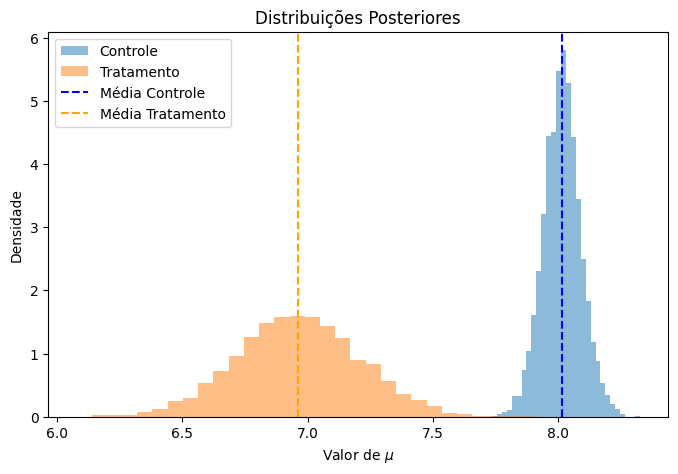

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(trace["mu_control"], bins=30, alpha=0.5, label="Controle", density=True)
plt.hist(trace["mu_treatment"], bins=30, alpha=0.5, label="Tratamento", density=True)
plt.axvline(np.mean(trace["mu_control"]), color='blue', linestyle='dashed', label='Média Controle')
plt.axvline(np.mean(trace["mu_treatment"]), color='orange', linestyle='dashed', label='Média Tratamento')
plt.title("Distribuições Posteriores")
plt.xlabel("Valor de $\\mu$")
plt.ylabel("Densidade")
plt.legend()
plt.show()

### gráfico PDF da diferença entre grupos

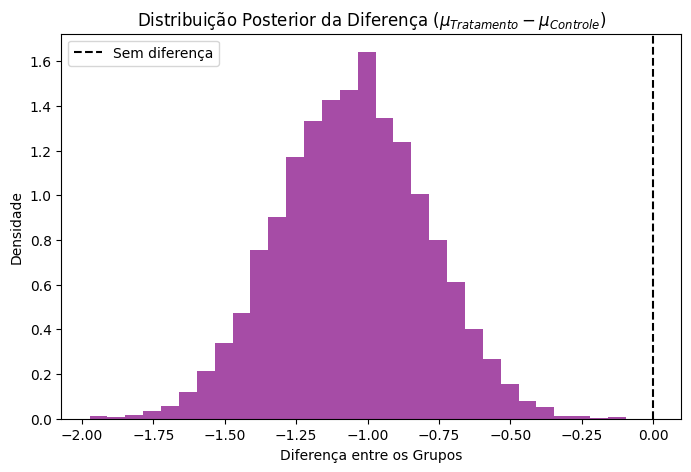

In [83]:
posterior_diff = trace["mu_treatment"] - trace["mu_control"]

plt.figure(figsize=(8, 5))
plt.hist(posterior_diff, bins=30, alpha=0.7, color='purple', density=True)
plt.axvline(0, color='black', linestyle='dashed', label='Sem diferença')
plt.title("Distribuição Posterior da Diferença ($\\mu_{Tratamento} - \\mu_{Controle}$)")
plt.xlabel("Diferença entre os Grupos")
plt.ylabel("Densidade")
plt.legend()
plt.show()

### Gráfico: Função de Distribuição Acumulada (CDF) ed cada grupo

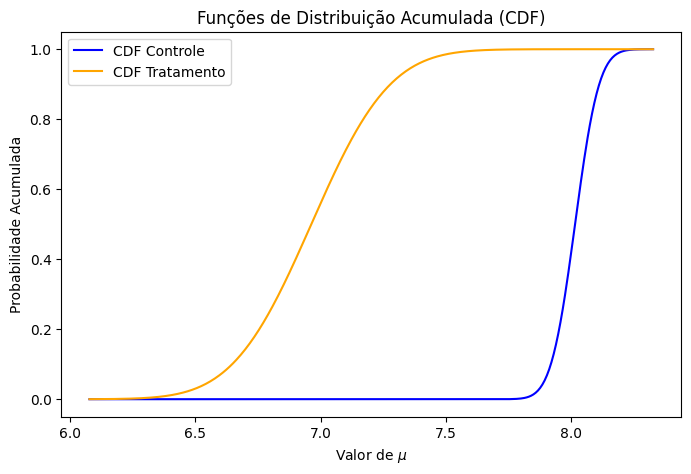

In [84]:

from scipy.stats import norm

x = np.linspace(min(trace["mu_control"].min(), trace["mu_treatment"].min()), 
                max(trace["mu_control"].max(), trace["mu_treatment"].max()), 500)

cdf_control = norm.cdf(x, loc=np.mean(trace["mu_control"]), scale=np.std(trace["mu_control"]))
cdf_treatment = norm.cdf(x, loc=np.mean(trace["mu_treatment"]), scale=np.std(trace["mu_treatment"]))

plt.figure(figsize=(8, 5))
plt.plot(x, cdf_control, label="CDF Controle", color='blue')
plt.plot(x, cdf_treatment, label="CDF Tratamento", color='orange')
plt.title("Funções de Distribuição Acumulada (CDF)")
plt.xlabel("Valor de $\\mu$")
plt.ylabel("Probabilidade Acumulada")
plt.legend()
plt.show()

## Ajuste RCT Bayesiano incremental

**AJUSTE ITERATIVO INCREMENTAL**

Atualização da probabilidade a cada entrada de dados na verossimilhança Reajuste (Novo Fit)

O modelo é ajustado repetidamente, adicionando mais dados a cada iteração. Como funciona:

Ajustes Incrementais:

* Inicia com os dados disponiveis em t0, o modelo bayesiano é ajustado, P1(t < c) é calculada.
* Em cada iteração, mais dados são incrementados na distribuição verossimilhança, o modelo bayesiano é ajustado novamente, P2(t <> c) é calculada.
* A probabilidade 𝑃(𝜇treatment<𝜇control) é recalculada após cada ajuste. 

Vantagens:
* Reflete diretamente o impacto da adição de novos dados na inferência.
* Mais alinhado com cenários de dados que chegam em tempo real.

Limitação:
* Pode ser muito lento, pois cada ponto no gráfico exige um novo ajuste do modelo.

In [ ]:
# Detectar número de núcleos
num_cores = multiprocessing.cpu_count()

# Modelo Bayesiano iterativo por semana
for week, new_data in enumerate(weekly_data, start=1):  # Para cada semana, começando pela semana 1
    control_data.extend(new_data["control"])  # Adiciona os dados semanais ao grupo controle
    treatment_data.extend(new_data["treatment"])  # Adiciona os dados semanais ao grupo tratamento
    print('\n')
    print("control_data: ", control_data) # visualizar dados de controle na semana
    print("treatment data: ", treatment_data) # visualizar dados de tratamento na semana

    # Criar o modelo Bayesiano para a semana atual
    with pm.Model() as model:
        # Priors (hipóteses iniciais sobre os parâmetros)
        mu_control = pm.Normal("mu_control", mu=7.5, sigma=5)
        # Prior para a média do grupo controle, centrada em 7.5 com incerteza moderada
        mu_treatment = pm.Normal("mu_treatment", mu=6.5, sigma=5)
        # Prior para a média do grupo tratamento, centrada em 6.5 com incerteza moderada
        sigma_control = pm.HalfNormal("sigma_control", sigma=2)
        # Prior para o desvio padrão do grupo controle (valores positivos)
        sigma_treatment = pm.HalfNormal("sigma_treatment", sigma=2)
        # Prior para o desvio padrão do grupo tratamento (valores positivos)


        # Likelihoods (como os dados observados se relacionam aos parâmetros)
        control = pm.Normal("control", mu=mu_control, sigma=sigma_control, observed=control_data)
        # Likelihood para o grupo controle
        treatment = pm.Normal("treatment", mu=mu_treatment, sigma=sigma_treatment, observed=treatment_data)
        # Likelihood para o grupo tratamento


        # Ajustar o modelo (amostragem MCMC)
        trace = pm.sample(500, tune=250, cores=num_cores, return_inferencedata=False, progressbar=False)
        # Realiza 500 amostras, com 250 iterações de ajuste (tuning), cores = max cores do sistema

    # Calcular a probabilidade de o tratamento ser melhor (menor que o controle)
    prob = (trace["mu_treatment"] < trace["mu_control"]).mean()
    # Calcula a fração de amostras onde mu_treatment < mu_control
    probabilities.append(prob)  # Armazena a probabilidade calculada para a semana
    weeks.append(week)  # Armazena o número da semana correspondente

# Criar um DataFrame com os resultados
results = pd.DataFrame({"Semana": weeks, "P(mu_treatment < mu_control)": probabilities})

# Exibir resultados
print(results)
# Mostra a evolução semanal das probabilidades



control_data:  [8.1, 7.5, 8.2, 8.0, 7.8, 8.2, 7.9]
treatment data:  [9.3, 10.2, 7.0, 9.4, 8.1, 9.5, 6.4, 6.3, 6.2, 6.5]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [mu_control, mu_treatment, sigma_control, sigma_treatment]
Sampling 12 chains for 250 tune and 500 draw iterations (3_000 + 6_000 draws total) took 78 seconds.




control_data:  [8.1, 7.5, 8.2, 8.0, 7.8, 8.2, 7.9, 8.1, 7.9, 8.0, 7.8]
treatment data:  [9.3, 10.2, 7.0, 9.4, 8.1, 9.5, 6.4, 6.3, 6.2, 6.5, 6.1, 6.3]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [mu_control, mu_treatment, sigma_control, sigma_treatment]
Sampling 12 chains for 250 tune and 500 draw iterations (3_000 + 6_000 draws total) took 77 seconds.




control_data:  [8.1, 7.5, 8.2, 8.0, 7.8, 8.2, 7.9, 8.1, 7.9, 8.0, 7.8, 8.3, 8.0]
treatment data:  [9.3, 10.2, 7.0, 9.4, 8.1, 9.5, 6.4, 6.3, 6.2, 6.5, 6.1, 6.3, 6.2, 6.0, 6.3]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [mu_control, mu_treatment, sigma_control, sigma_treatment]
Sampling 12 chains for 250 tune and 500 draw iterations (3_000 + 6_000 draws total) took 80 seconds.




control_data:  [8.1, 7.5, 8.2, 8.0, 7.8, 8.2, 7.9, 8.1, 7.9, 8.0, 7.8, 8.3, 8.0, 8.3, 8.0, 8.3, 7.9]
treatment data:  [9.3, 10.2, 7.0, 9.4, 8.1, 9.5, 6.4, 6.3, 6.2, 6.5, 6.1, 6.3, 6.2, 6.0, 6.3, 6.2, 6.1, 6.4, 6.6, 6.9, 6.3]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [mu_control, mu_treatment, sigma_control, sigma_treatment]
Sampling 12 chains for 250 tune and 500 draw iterations (3_000 + 6_000 draws total) took 84 seconds.




control_data:  [8.1, 7.5, 8.2, 8.0, 7.8, 8.2, 7.9, 8.1, 7.9, 8.0, 7.8, 8.3, 8.0, 8.3, 8.0, 8.3, 7.9, 8.6, 8.1, 8.6, 7.3, 7.39]
treatment data:  [9.3, 10.2, 7.0, 9.4, 8.1, 9.5, 6.4, 6.3, 6.2, 6.5, 6.1, 6.3, 6.2, 6.0, 6.3, 6.2, 6.1, 6.4, 6.6, 6.9, 6.3, 6.4, 6.5, 6.1, 6.6, 7.9, 6.3]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [mu_control, mu_treatment, sigma_control, sigma_treatment]
Sampling 12 chains for 250 tune and 500 draw iterations (3_000 + 6_000 draws total) took 83 seconds.


   Semana  P(mu_treatment < mu_control)
0       1                      0.564000
1       2                      0.765167
2       3                      0.946000
3       4                      0.997333
4       5                      1.000000


In [58]:
results

,Semana,P(mu_treatment < mu_control)
0,1,0.564000
1,2,0.765167
2,3,0.946000
3,4,0.997333
4,5,1.000000


### Gráfico: Evolução Temporal da probabilidade alvo

* Eixo 𝑥 Representa o tamanho cumulativo do conjunto de dados usado no ajuste.


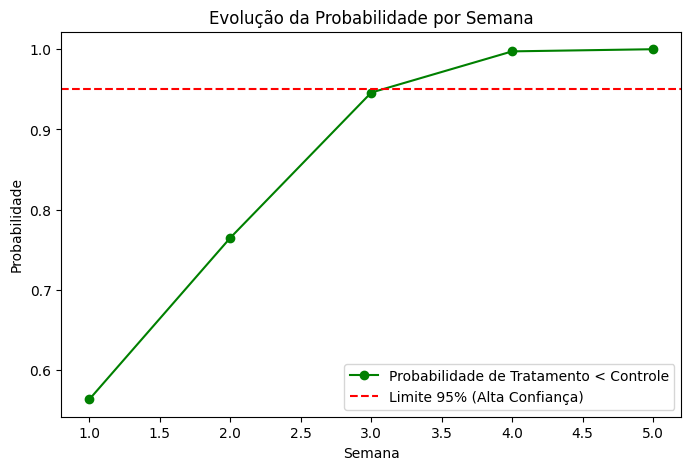

In [51]:
# Plotar o Gráfico de Probabilidades ao Longo do Tempo
plt.figure(figsize=(8, 5))
plt.plot(weeks, probabilities, marker='o', color='green', label="Probabilidade de Tratamento < Controle")
plt.axhline(0.95, color='red', linestyle='dashed', label="Limite 95% (Alta Confiança)")
plt.title("Evolução da Probabilidade por Semana")
plt.xlabel("Semana")
plt.ylabel("Probabilidade")
plt.legend()
plt.show()

### PDF vs CDF

<div align="center">

![curvas_PDF_CDF.png](images\curvas_PDF_CDF.png)

</div>

### gráfico distribuições posteriores de cada grupo PDF

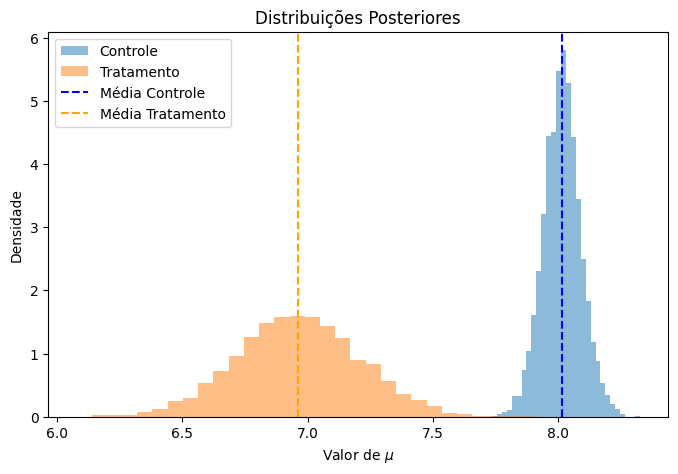

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(trace["mu_control"], bins=30, alpha=0.5, label="Controle", density=True)
plt.hist(trace["mu_treatment"], bins=30, alpha=0.5, label="Tratamento", density=True)
plt.axvline(np.mean(trace["mu_control"]), color='blue', linestyle='dashed', label='Média Controle')
plt.axvline(np.mean(trace["mu_treatment"]), color='orange', linestyle='dashed', label='Média Tratamento')
plt.title("Distribuições Posteriores")
plt.xlabel("Valor de $\\mu$")
plt.ylabel("Densidade")
plt.legend()
plt.show()


Eixo densidade de probabilidade: é uma função do quão provável é encontrar x em torno de um valor. 

Uma densidade mais **alta em y significa que o valor de 𝜇 é mais provável dentro da região**.

O **valor de y não é probabilidade direta**, é a densidade de probabilidade por unidade no eixo x.

Probabilidade em uma faixa:

* Para calcular a probabilidade da variável estar em uma faixa, integramos a densidade sobre a faixa (a área sob a curva ou barra no histograma).
Por exemplo, 𝑃(𝑎≤𝑋≤𝑏) é a área da curva de densidade entre 𝑥=𝑎 e 𝑥=𝑏, a largura de uma barra é 𝑑𝑥 e altura 𝑓(𝑥):

<div align="center">

![image.png](attachment:image.png)

</div>

A densidade de probabilidade pode ser maior que 1 em alguns pontos.

A área total sob a curva é igual a 1, isso representa 100% da probabilidade.

A Probabilidade para **um valor especifico** em uma distribuição continua é zero, pois a prob é a integral em uma faixa de uma função densidade prob. **P(X=a)=0 para variáveis contínuas.**




​


### gráfico PDF da diferença entre grupos

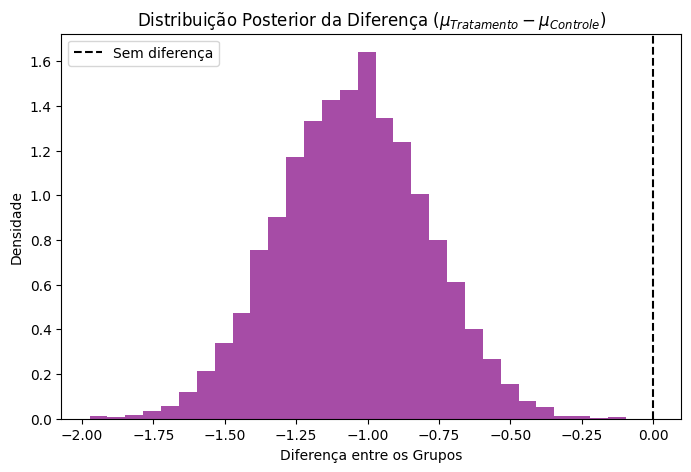

In [60]:
posterior_diff = trace["mu_treatment"] - trace["mu_control"]

plt.figure(figsize=(8, 5))
plt.hist(posterior_diff, bins=30, alpha=0.7, color='purple', density=True)
plt.axvline(0, color='black', linestyle='dashed', label='Sem diferença')
plt.title("Distribuição Posterior da Diferença ($\\mu_{Tratamento} - \\mu_{Controle}$)")
plt.xlabel("Diferença entre os Grupos")
plt.ylabel("Densidade")
plt.legend()
plt.show()

Distribuição Centrada em 0:

* O tratamento e o controle têm resultados muito próximos.
O tratamento pode não ser significativamente diferente do controle.

Distribuição Principalmente à Direita de 0:

* O tratamento é maior que o controle.
A probabilidade de μtreatment > μcontrol é alta.

Distribuição Principalmente à Esquerda de 0:
* O controle é maior que o tratamento.
* A probabilidade de μtreatment < μcontrol é alta.

Amplitude da Distribuição:

* Se a distribuição for muito larga, a incerteza é alta.
* Se for estreita, a estimativa é mais precisa.

### Gráfico: Função de Distribuição Acumulada (CDF) ed cada grupo

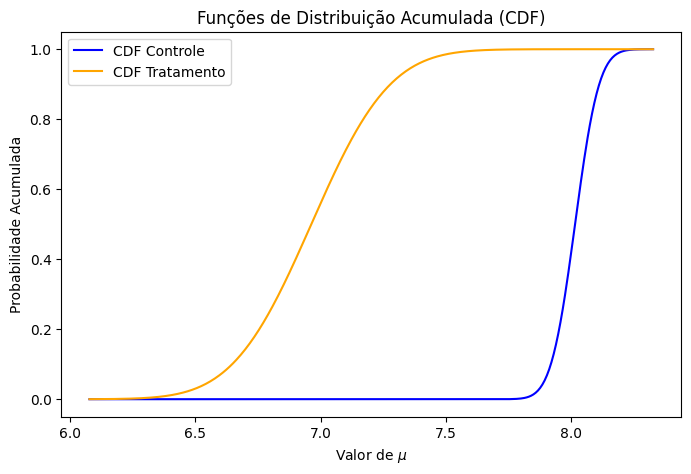

In [ ]:
from scipy.stats import norm

x = np.linspace(min(trace["mu_control"].min(), trace["mu_treatment"].min()), 
                max(trace["mu_control"].max(), trace["mu_treatment"].max()), 500)

cdf_control = norm.cdf(x, loc=np.mean(trace["mu_control"]), scale=np.std(trace["mu_control"]))
cdf_treatment = norm.cdf(x, loc=np.mean(trace["mu_treatment"]), scale=np.std(trace["mu_treatment"]))

plt.figure(figsize=(8, 5))
plt.plot(x, cdf_control, label="CDF Controle", color='blue')
plt.plot(x, cdf_treatment, label="CDF Tratamento", color='orange')
plt.title("Funções de Distribuição Acumulada (CDF)")
plt.xlabel("Valor de $\\mu$")
plt.ylabel("Probabilidade Acumulada")
plt.legend()
plt.show()

O que o CDF Mostra:Probabilidade acumulada até um valor específico (𝑃(𝑋≤𝑥)).

Como Interpretar: Leia o valor no eixo 𝑦 para o valor correspondente no eixo 𝑥.

Use a diferença entre 𝐶𝐷𝐹(𝑏) e 𝐶𝐷𝐹(𝑎) para calcular probabilidades em intervalos.

Aplicação em Testes A/B: Comparar probabilidades acumuladas entre dois grupos para identificar diferenças nas distribuições.

Para x = 6.5:

* CDF controle = 0.8 (80% das amostras estão abaixo de 6.5)
* CDF tratamento = 0.9 (90% das amostras estão abaixo de 6.5)
* Tratamento está concentrado em valores mais baixos que o controle

# Definição e atualização de priors avançada

atenção com a **definição das priors com dados historicos** (tipo de distribição assumida e valor dos parametros)

<div align="center">

![fluxo_estimativa_priors](images\fluxo_estimativa_priors.png)

</div>